In [1]:
import os
import numpy as np
import random
import string
from matplotlib import pyplot as plt

In [2]:
import cv2

In [16]:
def to_video(images_folder,annotations_folder,video_file,fps=30):
    try:
        frames = sorted(os.listdir(images_folder))
    except Exception as e:
        print(e)
        return
    
    if len(frames)==0:
        return
    
    frame_count = 0
    im = cv2.imread(os.path.join(images_folder,frames[0]))
    size = (im.shape[1],im.shape[0])

    try:
        result = cv2.VideoWriter(video_file,cv2.VideoWriter_fourcc(*'MJPG'),fps,size)
        for frame_count, frame in enumerate(frames):
            print('\r'+os.path.join(images_folder,frame),end='')
            
            im = cv2.imread(os.path.join(images_folder,frame))
            im = cv2.resize(im,size)
            mask = cv2.imread(os.path.join(annotations_folder,frame))
            mask = cv2.cvtColor(cv2.resize(mask,size),cv2.COLOR_BGR2GRAY)
            
            im[mask>0,:] = 0
            im[mask>0,1] = 255
            
            
            if frame_count == 0:
                plt.imshow(cv2.cvtColor(im,cv2.COLOR_RGB2BGR))
                plt.show()
            result.write(im)
            
            cv2.imshow('frames', im)
            
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
    except Exception as e:
        print(e)
        raise(e)
    finally:
        result.release()
        cv2.destroyAllWindows()

In [4]:
base_folder = '_out/'

In [7]:
folders = ['30']

_out/30\images\00000633.png

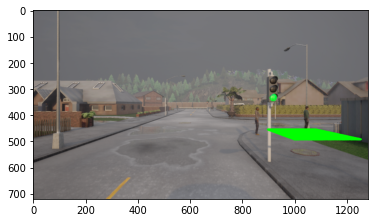

_out/30\images\00001227.png

In [17]:
for folder in folders:
    to_video(os.path.join(base_folder,folder,'images'),os.path.join(base_folder,folder,'masks'),os.path.join(base_folder,folder,'video.mp4'))